### Import all necessary packages

In [1]:
import numpy as np
import scipy as sp
from scipy import ndimage as ndi
from scipy import signal
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from skimage.restoration import denoise_tv_chambolle
from skimage.draw import rectangle
from skimage.util import img_as_float
from skimage.metrics import structural_similarity
import matplotlib.pyplot as plt
import matplotlib.colors as clr

### Utility functions

##### Function to normalize input to [0 1] range

In [2]:
def normalise(arr):
    return (arr-np.amin(arr))/(np.amax(arr)-np.amin(arr))

##### All-in-one function to perform Fourier transform of input, get magnitude, center on low frequency (for display purposes)

In [3]:
def numpy_fft2(im):
    F = np.fft.fft2(im)     # Perform 2-dimensional discrete Fourier transform 
    C = np.fft.fftshift(F)  # Center spectrum on minimum frequency
    Mag = np.abs(C).real    # Get magnitude and phase
    Ph  = np.angle(C).real    
    return Mag, Ph

##### Function to apply a raised cosine taper to the input data, to help reduce artifacts araising from DFT periodicity

Reference blog post: [_"Fourier transform visualization using windowing"_](https://blogs.mathworks.com/steve/2009/12/04/fourier-transform-visualization-using-windowing)

In [4]:
def raised_cosine(im):
    m, n = np.shape(im)
    w1 = np.cos(np.linspace(-np.pi/2, np.pi/2, m))
    w1 = w1[:, None] 
    w2 = np.cos(np.linspace(-np.pi/2, np.pi/2, n))
    w = w1*w2
    return normalise(im * w)

##### The footprint suppression filter is completed by convolving a 2S Gaussian disk with the maxima or geometric elements defined automaticalyl or by the user on the spectrum

Initially this step used `convolve` and `Gaussian2DKernel` [from Astropy](https://docs.astropy.org/en/stable/convolution/kernels.html) but then moved to `Scipy` for both, with significantly improved performance (you can read about it [here](https://github.com/mycarta/t21-hack-footprint/blob/main/speed_up_convolution_example.ipynb) and [here](https://github.com/mycarta/t21-hack-footprint/blob/main/scipy_gaussian_kernel_example.ipynb)).

In [5]:
def scipy_gaussian_2D(std):
    '''
    2D Gaussian filter kernel similar to astropy\'s Gaussian2DKernel
    (https://docs.astropy.org/en/stable/api/astropy.convolution.Gaussian2DKernel.html#astropy.convolution.Gaussian2DKernel)
    using scipy.signal.gaussian 
    (and inspired by https://gist.github.com/thomasaarholt/267ec4fff40ca9dff1106490ea3b7567)
    
    Parameters: 
    std (int) : standard deviation of the Gaussian in pixels
    
    Returns:
    out (2D array): 2D Gaussian filter kernel
    '''
    ksp1D = signal.gaussian(std*8+1, std)
    ksp2D = np.outer(ksp1D, ksp1D)
    ksp2D /= (2*np.pi*(std**2))
    return ksp2D

##### Function to pad input to a square NxN array. Not necessary if input arrays are square to begin with

In [6]:
def pad_next_square_size(im):
    """Function to pad a rectangualr image to a square image.
    Parameters:
    im (2D array): input grayscale image
    
    Returns:
    out (2D array): padded input image
    padding (slice object): a slice object that can be later passed to reverse_padding
    
    Example:
    out, padding = pad_next_square_size(im)
    """
    m, n = np.shape(im) # get input shape
    deficit = max([m,n])- min([m,n])  # get deficit between size lengths

    # difference in dimensions is even, pad both sides of short dimension by deficit//2
    if deficit%2 == 0: 
        deficit1 = deficit//2
        deficit2 = deficit//2
    
    # difference in dimensions is odd, pad one side by deficit//2 +1
    else:
        deficit1 = deficit//2
        deficit2 = deficit1+1
        
    if m > n:
        print("Padded image columns")
        return (np.pad(im,((0,0), (deficit1,deficit2)), 'reflect'), slice(deficit1, -deficit2))
        
    else:
        print("Padded image rows")
        return (np.pad(im,((deficit1,deficit2), (0,0)), 'reflect'), slice(deficit1, -deficit2))

##### Function to reverse padding

In [7]:
def reverse_padding(im, filtered_im, slc):
    m, n = np.shape(im) # get input shape
     
    if m > n:
        print("Unpadding image columns")
        return filtered_im[:, slc]       
    else:
        print("Unpadding image rows")
        return filtered_im[slc, :]      

##### Function to calculate 2D sobel edges

In [8]:
def Sobel_2d(data):
    '''2D Sobel filter'''
    dx = ndi.sobel(data, 0)  # horizontal derivative
    dy = ndi.sobel(data, 1)  # vertical derivative
    mag = np.hypot(dx, dy)      # magnitude
    mag *= 255.0 / np.max(mag)  # normalize
    return mag

### Now we can run a complete seismic example

Let's use some time slices from the [Penobscot 3D](https://terranubis.com/datainfo/Penobscot), which is available under a [CC BY-SA license](https://creativecommons.org/licenses/by-sa/3.0/)

#### Import the seismic data previously saved to npy file and access time slice at 948 ms which is at about the median time of Horizon B

In [9]:
penobscot = np.load('images_and_data/penobscot.npy')

In [10]:
np.shape(penobscot)

(461, 441, 76)

In [11]:
samples = np.load('images_and_data/samples.npy')
samples

array([ 900.,  904.,  908.,  912.,  916.,  920.,  924.,  928.,  932.,
        936.,  940.,  944.,  948.,  952.,  956.,  960.,  964.,  968.,
        972.,  976.,  980.,  984.,  988.,  992.,  996., 1000., 1004.,
       1008., 1012., 1016., 1020., 1024., 1028., 1032., 1036., 1040.,
       1044., 1048., 1052., 1056., 1060., 1064., 1068., 1072., 1076.,
       1080., 1084., 1088., 1092., 1096., 1100., 1104., 1108., 1112.,
       1116., 1120., 1124., 1128., 1132., 1136., 1140., 1144., 1148.,
       1152., 1156., 1160., 1164., 1168., 1172., 1176., 1180., 1184.,
       1188., 1192., 1196., 1200.])

In [12]:
slc948 = np.where(samples==948)[0]
print(slc948)

[12]


In [13]:
t948 = normalise(np.squeeze(penobscot[:,:,slc948]))
np.shape(t948)

(461, 441)

#### Display time slice at 948 ms

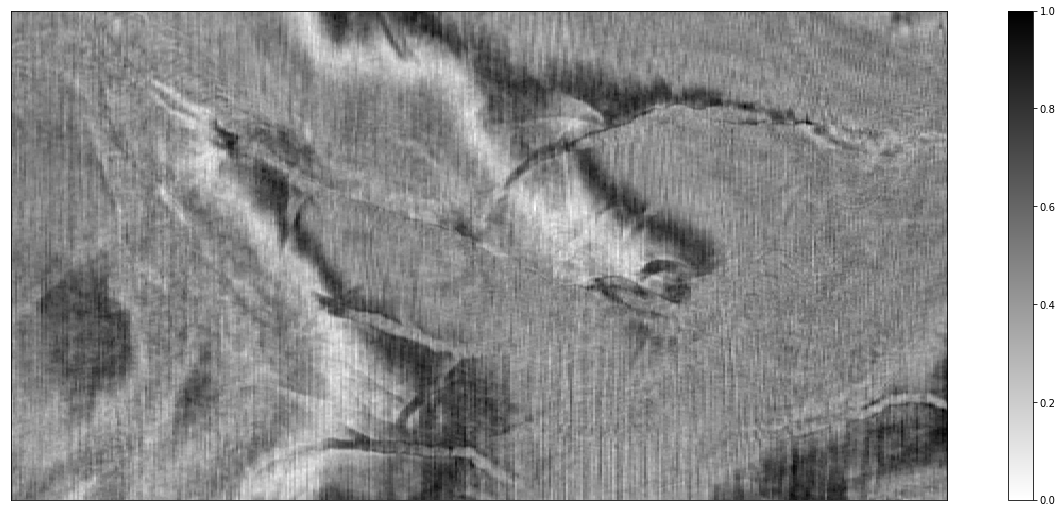

In [14]:
fig = plt.figure(figsize=(22, 9))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(t948, cmap='gray_r', aspect = 0.5, origin = 'lower', interpolation = 'none');  
# aspect = 0.5 since the Inline bin size is 12.5 m/line and the Crossline bin size is 25 m/line
plt.colorbar();

#### View spectrum of time slice at 948 ms

In [15]:
test1, slc = pad_next_square_size(t948)

Padded image columns


In [16]:
slc

slice(10, -10, None)

In [17]:
A, _ = numpy_fft2(raised_cosine(test1))
Ag = denoise_tv_chambolle(np.log(A +1), weight=0.2)  

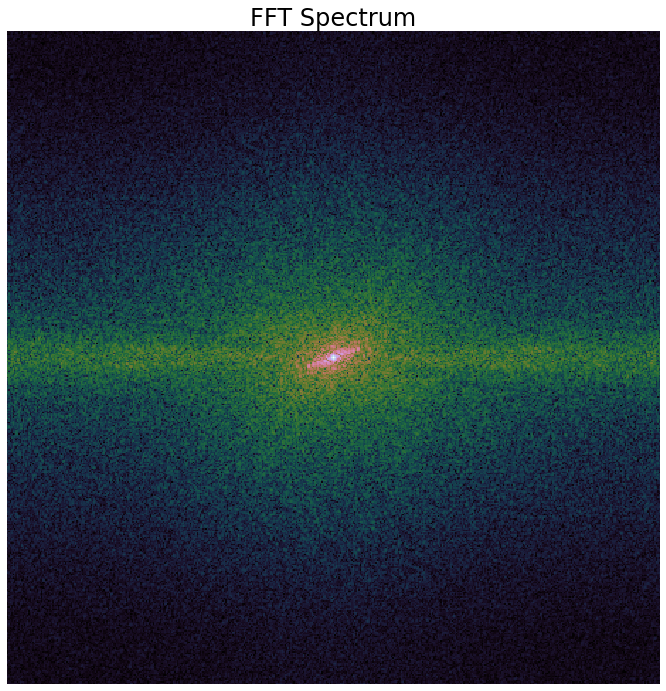

In [18]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('FFT Spectrum', fontsize=24)
plt.imshow(np.log(A +1),  cmap='cubehelix', origin = 'lower', interpolation = 'none'), plt.axis('off');

#### Design the footprint removal filter
In this case instead of automatic detection of maxima (as in the tutorial), we use of rectangular filters defined by hand with `skimage.draw`. We want to remove the horizontal band, but preserve the central portion of the spectum.

In [19]:
rec= np.zeros(np.shape(A), dtype=np.uint8)
start1 = (np.shape(Ag)[0]//2+5,0)
end1 = (np.shape(Ag)[0]//2-5,np.shape(Ag)[0]//2-50)
rr1, cc1 = rectangle(start1, end=end1, shape=test1.shape)
rec[rr1, cc1] = 1

start2 = (np.shape(Ag)[0]//2+5,np.shape(Ag)[0]//2+50)
end2 = (np.shape(Ag)[0]//2-5,np.shape(Ag)[0]-1)
rr2, cc2 = rectangle(start2, end=end2, shape=test1.shape)
rec[rr2, cc2] = 1

#### Show filter design mask on top of spectrum

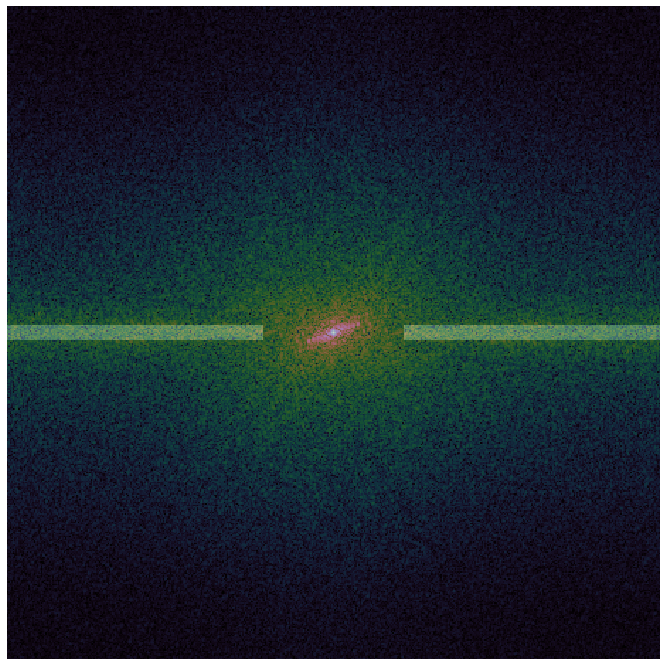

In [20]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(np.log(A +1),  cmap='cubehelix', origin = 'lower', interpolation = 'none'), plt.axis('off');
plt.imshow(rec,  cmap='gray', origin = 'lower', interpolation = 'none', alpha = 0.2), plt.axis('off');

### N.B. Allowing users to design rectangle and ellipse filters interactively would be a good feature to have for the app

#### Apply gaussian taper and display final filter on top of spectum

In [21]:
gauss_kernel = scipy_gaussian_2D(11)
filter00 = signal.fftconvolve(rec, gauss_kernel, mode='same')
filter00 = normalise(filter00)

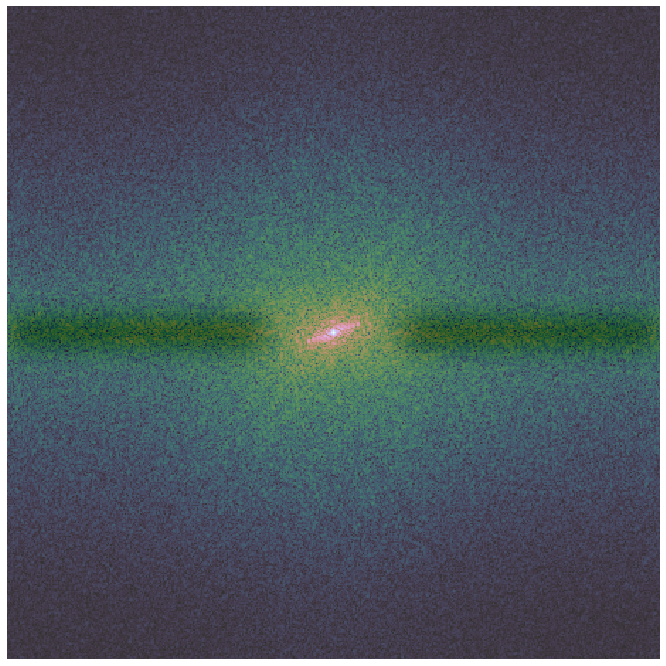

In [22]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(np.log(A +1),  cmap='cubehelix', origin = 'lower', interpolation = 'none'), plt.axis('off');
plt.imshow(1-filter00, cmap='gray', origin = 'lower', interpolation = 'none', alpha = 0.2), plt.axis('off');

#### Apply filter and show input, output, difference

In [23]:
filtered1 = ifft2(np.multiply(ifftshift(1-filter00), fft2(test1.copy()))).real
print(np.shape(filtered1))

filtered1 = reverse_padding(t948, filtered1, slc)
print(np.shape(filtered1))

(461, 461)
Unpadding image columns
(461, 441)


In [24]:
diff = img_as_float(t948 - filtered1)

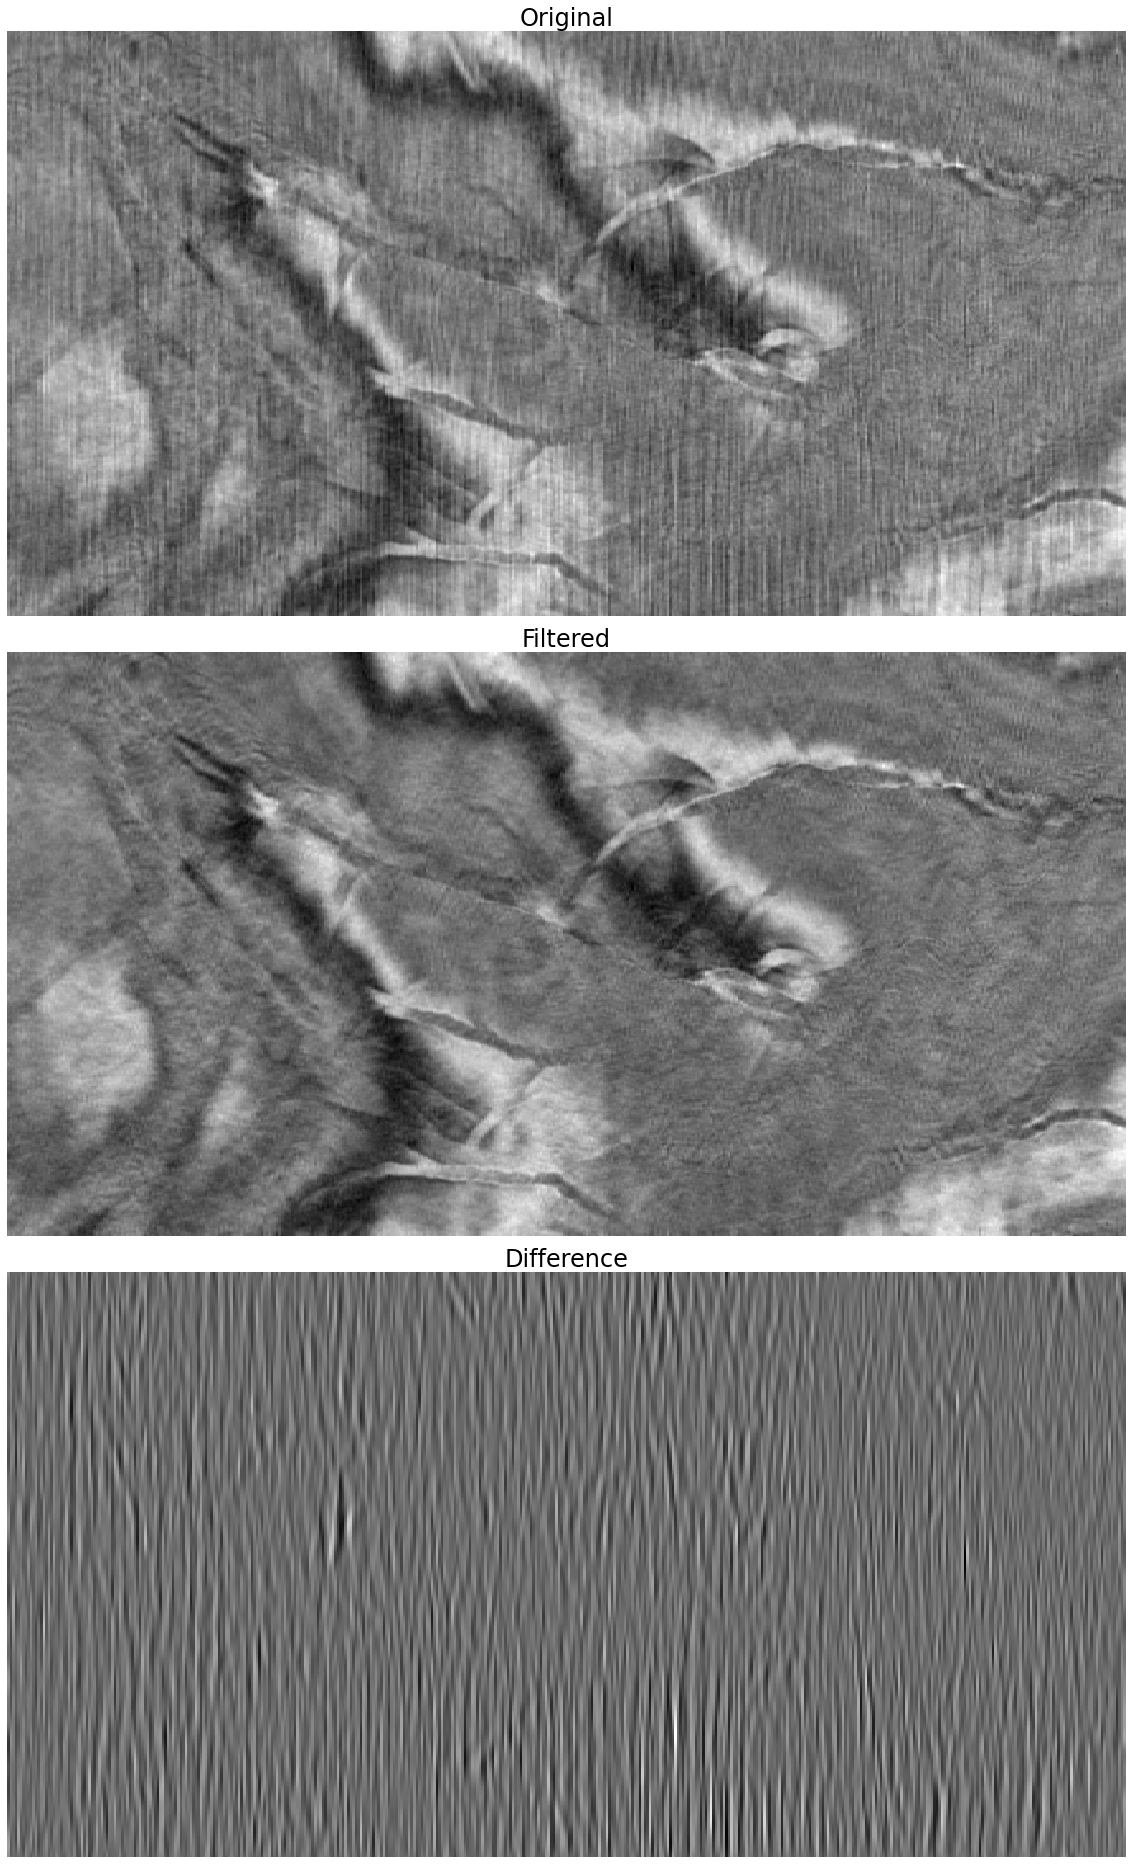

In [25]:
# display results
fig, axes = plt.subplots(3, 1, figsize=(16, 26), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(t948, cmap='gray', aspect = 0.5, origin = 'lower', interpolation = 'none')
ax[0].axis('off')
ax[0].set_title('Original', fontsize=24)

ax[1].imshow(filtered1, cmap='gray', aspect = 0.5, origin = 'lower', interpolation = 'none')
ax[1].axis('off')
ax[1].set_title('Filtered', fontsize=24)

ax[2].imshow(diff, cmap='gray', aspect = 0.5, origin = 'lower', interpolation = 'none')
ax[2].axis('off')
ax[2].set_title('Difference', fontsize=24)

fig.tight_layout()
plt.show()

#### Now we test the same filter on a deeper time slice, to ensure it is not too aggressive
The time slice at 1136 ms is at about the median time of Horizon C

In [26]:
slc1136 = np.where(samples==1136)[0]
print(slc1136)

[59]


In [27]:
t1136 = normalise(np.squeeze(penobscot[:,:,slc1136]))

In [28]:
test2, slc = pad_next_square_size(t1136)

Padded image columns


#### Apply filter and show input, output, difference

In [29]:
filtered2 = ifft2(np.multiply(ifftshift(1-filter00), fft2(test2.copy()))).real
print(np.shape(filtered2))

filtered2 = reverse_padding(t1136, filtered2, slc)
print(np.shape(filtered2))

(461, 461)
Unpadding image columns
(461, 441)


In [30]:
diff = img_as_float(t1136 - filtered2)

In [ ]:
# display results
fig, axes = plt.subplots(3, 1, figsize=(16, 26), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(t1136, cmap='gray', aspect = 0.5, origin = 'lower', interpolation = 'none')
ax[0].axis('off')
ax[0].set_title('Original', fontsize=24)

ax[1].imshow(filtered2, cmap='gray', aspect = 0.5, origin = 'lower', interpolation = 'none')
ax[1].axis('off')
ax[1].set_title('Filtered', fontsize=24)

ax[2].imshow(diff, cmap='gray', aspect = 0.5, origin = 'lower', interpolation = 'none')
ax[2].axis('off')
ax[2].set_title('Difference', fontsize=24)

fig.tight_layout()
plt.show()

#### Apply filter to the whole cube 

### N.B. The cell below is not efficient. It is the code to apply the 2D filter to the full 3D volume. It needs to be rewritten using broadcasting. This is one of the goals of the hackathon.

In [ ]:
penobscot_filt = penobscot.copy() 

## loop through time slices
for i,_ in enumerate(samples): 

    ## pad slice
    ts, slc = pad_next_square_size(penobscot_filt[:,:,i])  
    
    ## do all the FFT magic to apply the filter to the slice 
    temp = ifft2(np.multiply(ifftshift(1-filter00), fft2(ts.copy()))).real
    
    ## reverse the padding  
    penobscot_filt[:,:,i] = reverse_padding(penobscot[:,:,i], temp, slc) 

#### OK ! it run, and it was not too slow. Still, it is good to speed up in anticipation of MUCH LARGER seismic 3D volumes.

#### BUT: did it work?

Let's test by extracting from this filtered 3D at the same time (948 ms) where the filter was designed and applied first as a 2D process, then compare both visually and with structural similarity.

In [ ]:
test948 = normalise(np.squeeze(penobscot_filt[:,:,slc948]))

In [ ]:
# display results
fig, axes = plt.subplots(2, 1, figsize=(24, 24), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(filtered1, cmap='gray', aspect = 0.5, origin = 'lower', interpolation = 'none')
ax[0].axis('off')
ax[0].set_title('Single filtered slice', fontsize=24)

ax[1].imshow(test948, cmap='gray', aspect = 0.5, origin = 'lower', interpolation = 'none')
ax[1].axis('off')
ax[1].set_title('Same slice from filtered 3D', fontsize=24)

fig.tight_layout()
plt.show()

In [ ]:
structural_similarity(filtered1.astype('float32'), test948)